In [1]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
!pip install kmodes
!pip install catboost


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
import shap


In [4]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv",sep="\t")
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
df.describe().round()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.0,2240.0,2216.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0
mean,5592.0,1969.0,52247.0,0.0,1.0,49.0,304.0,26.0,167.0,38.0,27.0,44.0,2.0,4.0,3.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
std,3247.0,12.0,25173.0,1.0,1.0,29.0,337.0,40.0,226.0,55.0,41.0,52.0,2.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1893.0,1730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
25%,2828.0,1959.0,35303.0,0.0,0.0,24.0,24.0,1.0,16.0,3.0,1.0,9.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
50%,5458.0,1970.0,51382.0,0.0,0.0,49.0,174.0,8.0,67.0,12.0,8.0,24.0,2.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
75%,8428.0,1977.0,68522.0,1.0,1.0,74.0,504.0,33.0,232.0,50.0,33.0,56.0,3.0,6.0,4.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0
max,11191.0,1996.0,666666.0,2.0,2.0,99.0,1493.0,199.0,1725.0,259.0,263.0,362.0,15.0,27.0,28.0,13.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,11.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

to decrease the number of columns, I combine binary variables in columns 20-24+28 into one column since they 

In [8]:
df = df.rename(columns={'Response': 'AcceptedCmp6'})


In [9]:
 # Create a dictionary to map the campaign numbers to the column names
campaign_dict = {'AcceptedCmp1': 1, 'AcceptedCmp2': 2, 'AcceptedCmp3': 3,
                 'AcceptedCmp4': 4, 'AcceptedCmp5': 5, 'AcceptedCmp6': 6}

# Loop through the rows and find the campaign where the customer accepted the offer
for i in range(len(df)):
    for col, campaign in campaign_dict.items():
        if df.loc[i, col] == 1:
            df.loc[i, 'AcceptedCmp'] = campaign
            break
    else:
        df.loc[i, 'AcceptedCmp'] = 0

# Delete the original campaign columns
df.drop(columns=campaign_dict.keys(), inplace=True)


making sure that these columns are not integer type

In [10]:
df['Marital_Status'] = df['Marital_Status'].astype('string')
df['Education'] = df['Education'].astype('string')

df['AcceptedCmp'] = df['AcceptedCmp'].astype('string')
# df['Teenhome'] = df['Teenhome'].astype('string')
# df['Kidhome'] = df['Kidhome'].astype('string')
df['Complain'] = df['Complain'].astype('string')

creating a new column age and enrollment_time and deleting year_birth and Dt_customer columns

In [11]:


# calculate age based on Year_Birth
current_year = dt.datetime.now().year
df['Age'] = current_year - df['Year_Birth']

# convert 'Dt_Customer' to datetime format and calculate enrollment time
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Enrollment_time'] = ((dt.datetime.now() - df['Dt_Customer']).dt.days / 12).round(1)

# drop the original columns
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)



In [12]:
# deleting the z_costcontact and Z_revenue columns as they have zero variation and therefore no use for clustering purposes 
df = df.drop(columns=['Z_CostContact', 'Z_Revenue', 'ID'])

In [13]:
df.describe().round()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Enrollment_time
count,2216.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0
mean,52247.0,0.0,1.0,49.0,304.0,26.0,167.0,38.0,27.0,44.0,2.0,4.0,3.0,6.0,5.0,54.0,297.0
std,25173.0,1.0,1.0,29.0,337.0,40.0,226.0,55.0,41.0,52.0,2.0,3.0,3.0,3.0,2.0,12.0,17.0
min,1730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,268.0
25%,35303.0,0.0,0.0,24.0,24.0,1.0,16.0,3.0,1.0,9.0,1.0,2.0,0.0,3.0,3.0,46.0,283.0
50%,51382.0,0.0,0.0,49.0,174.0,8.0,67.0,12.0,8.0,24.0,2.0,4.0,2.0,5.0,6.0,53.0,298.0
75%,68522.0,1.0,1.0,74.0,504.0,33.0,232.0,50.0,33.0,56.0,3.0,6.0,4.0,8.0,7.0,64.0,312.0
max,666666.0,2.0,2.0,99.0,1493.0,199.0,1725.0,259.0,263.0,362.0,15.0,27.0,28.0,13.0,20.0,130.0,326.0


In [14]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,AcceptedCmp,Age,Enrollment_time
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,6.0,66,323.2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0.0,69,277.4
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0.0,58,294.0
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0.0,39,279.6
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0.0,42,281.4


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   string 
 1   Marital_Status       2240 non-null   string 
 2   Income               2216 non-null   float64
 3   Kidhome              2240 non-null   int64  
 4   Teenhome             2240 non-null   int64  
 5   Recency              2240 non-null   int64  
 6   MntWines             2240 non-null   int64  
 7   MntFruits            2240 non-null   int64  
 8   MntMeatProducts      2240 non-null   int64  
 9   MntFishProducts      2240 non-null   int64  
 10  MntSweetProducts     2240 non-null   int64  
 11  MntGoldProds         2240 non-null   int64  
 12  NumDealsPurchases    2240 non-null   int64  
 13  NumWebPurchases      2240 non-null   int64  
 14  NumCatalogPurchases  2240 non-null   int64  
 15  NumStorePurchases    2240 non-null   i

In [16]:
# deleting rows with null 'Income' values
df = df.dropna(subset=['Income']).reset_index(drop=True)

In [17]:
# select columns with data type 'object'
object_cols = df.select_dtypes(include=['string']).columns

# get the index of the object columns
object_cols_index = object_cols.to_list()

object_cols_index = [df.columns.get_loc(col) for col in object_cols]


print(object_cols_index)  


[0, 1, 17, 18]


In [18]:
df_scaled=df.copy()
# select only the non-object columns
non_obj_cols = df_scaled.select_dtypes(exclude=['string']).columns

# apply robust standization to the non-object columns as there are outliers in the data. 
scaler = RobustScaler()
df_scaled[non_obj_cols] = scaler.fit_transform(df_scaled[non_obj_cols])


df_scaled.describe().round()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Enrollment_time
count,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0,2216.0
mean,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,0.0,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-1.0,-1.0,-0.0,-1.0,-2.0,-1.0,-1.0
25%,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-1.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
max,19.0,2.0,2.0,1.0,3.0,6.0,8.0,5.0,8.0,6.0,6.0,6.0,6.0,2.0,4.0,4.0,1.0


applying the elbow method 

In [19]:
cost = []
for num_clusters in list(range(1,8)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_scaled, categorical=object_cols_index)
    cost.append(kproto.cost_)




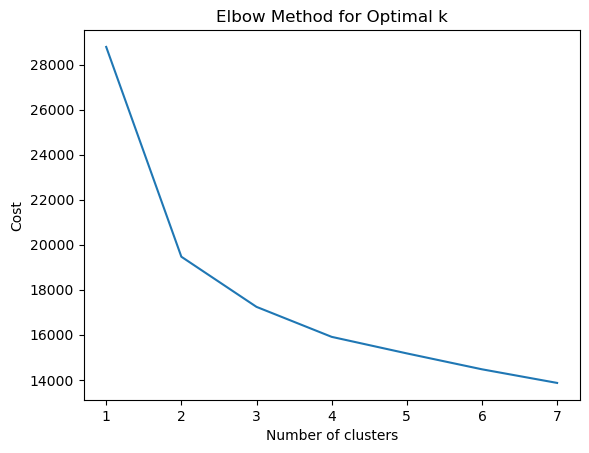

In [20]:
plt.plot(range(1, 8), cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

K=3 seems like a good choice. so lets re-train with k=3 this time with more initializations.

In [21]:
    kproto = KPrototypes(n_clusters=4, init='Cao', n_init=50)
    kproto.fit_predict(df_scaled, categorical=object_cols_index)


array([1, 2, 3, ..., 3, 3, 2], dtype=uint16)

I add the labels to the original DF since I will apply Catboost to now labeled dataset to understand feature importance through SHAP values.

In [22]:
df['cluster']=kproto.labels_
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,AcceptedCmp,Age,Enrollment_time,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,6.0,66,323.2,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0.0,69,277.4,2
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0.0,58,294.0,3
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0.0,39,279.6,2
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0.0,42,281.4,0


there is no need for train test split and worry about overfitting because we wont use the model for prediction purposes but to explore which features are important for each of the three clusters. So I first train a 
catboos model for the existence of many categorical features. I will then analyze feature importance through SHAP values. 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   string 
 1   Marital_Status       2216 non-null   string 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   MntWines             2216 non-null   int64  
 7   MntFruits            2216 non-null   int64  
 8   MntMeatProducts      2216 non-null   int64  
 9   MntFishProducts      2216 non-null   int64  
 10  MntSweetProducts     2216 non-null   int64  
 11  MntGoldProds         2216 non-null   int64  
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   i

In [24]:
df['Enrollment_time'] = df['Enrollment_time'].astype('int')
df['Income'] = df['Income'].astype('int')
df['cluster'] = df['cluster'].astype('int')


In [25]:
X = df.drop('cluster', axis=1)
y = df['cluster']

catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='MultiClass', eval_metric='Accuracy', random_seed=42)

catboost.fit(X, y, cat_features=object_cols_index)




0:	learn: 0.8280686	total: 67.1ms	remaining: 6.64s
1:	learn: 0.8727437	total: 78.9ms	remaining: 3.87s
2:	learn: 0.8948556	total: 97.7ms	remaining: 3.16s
3:	learn: 0.8962094	total: 109ms	remaining: 2.63s
4:	learn: 0.9097473	total: 120ms	remaining: 2.28s
5:	learn: 0.9246390	total: 131ms	remaining: 2.05s
6:	learn: 0.9187726	total: 141ms	remaining: 1.87s
7:	learn: 0.9223827	total: 154ms	remaining: 1.77s
8:	learn: 0.9205776	total: 167ms	remaining: 1.68s
9:	learn: 0.9323105	total: 180ms	remaining: 1.62s
10:	learn: 0.9354693	total: 190ms	remaining: 1.53s
11:	learn: 0.9413357	total: 200ms	remaining: 1.46s
12:	learn: 0.9408845	total: 210ms	remaining: 1.4s
13:	learn: 0.9431408	total: 220ms	remaining: 1.35s
14:	learn: 0.9472022	total: 229ms	remaining: 1.3s
15:	learn: 0.9517148	total: 239ms	remaining: 1.26s
16:	learn: 0.9535199	total: 249ms	remaining: 1.22s
17:	learn: 0.9544224	total: 259ms	remaining: 1.18s
18:	learn: 0.9571300	total: 271ms	remaining: 1.15s
19:	learn: 0.9553249	total: 281ms	remain

[0, 1, 3, 4, 17, 18]


In [26]:
object_cols_index

[0, 1, 17, 18]

In [27]:
explainer = shap.TreeExplainer(catboost, cat_features=object_cols_index)

# # Compute SHAP values for the training data
shap_values = explainer(X).values


In [28]:
shap_values.shape

(2216, 21, 4)

In [29]:
X['Complain'].value_counts()


0    2195
1      21
Name: Complain, dtype: Int64

In [30]:
X['Education'].value_counts()


Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: Int64

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            2216 non-null   string
 1   Marital_Status       2216 non-null   string
 2   Income               2216 non-null   int64 
 3   Kidhome              2216 non-null   int64 
 4   Teenhome             2216 non-null   int64 
 5   Recency              2216 non-null   int64 
 6   MntWines             2216 non-null   int64 
 7   MntFruits            2216 non-null   int64 
 8   MntMeatProducts      2216 non-null   int64 
 9   MntFishProducts      2216 non-null   int64 
 10  MntSweetProducts     2216 non-null   int64 
 11  MntGoldProds         2216 non-null   int64 
 12  NumDealsPurchases    2216 non-null   int64 
 13  NumWebPurchases      2216 non-null   int64 
 14  NumCatalogPurchases  2216 non-null   int64 
 15  NumStorePurchases    2216 non-null   int64 
 16  NumWeb

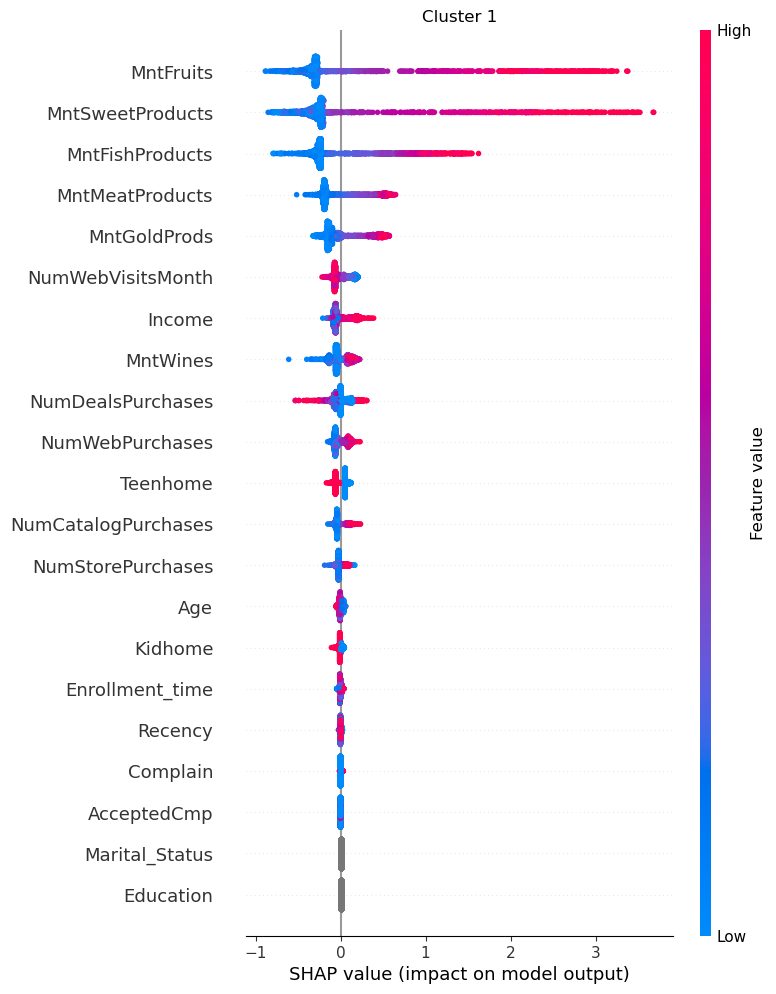

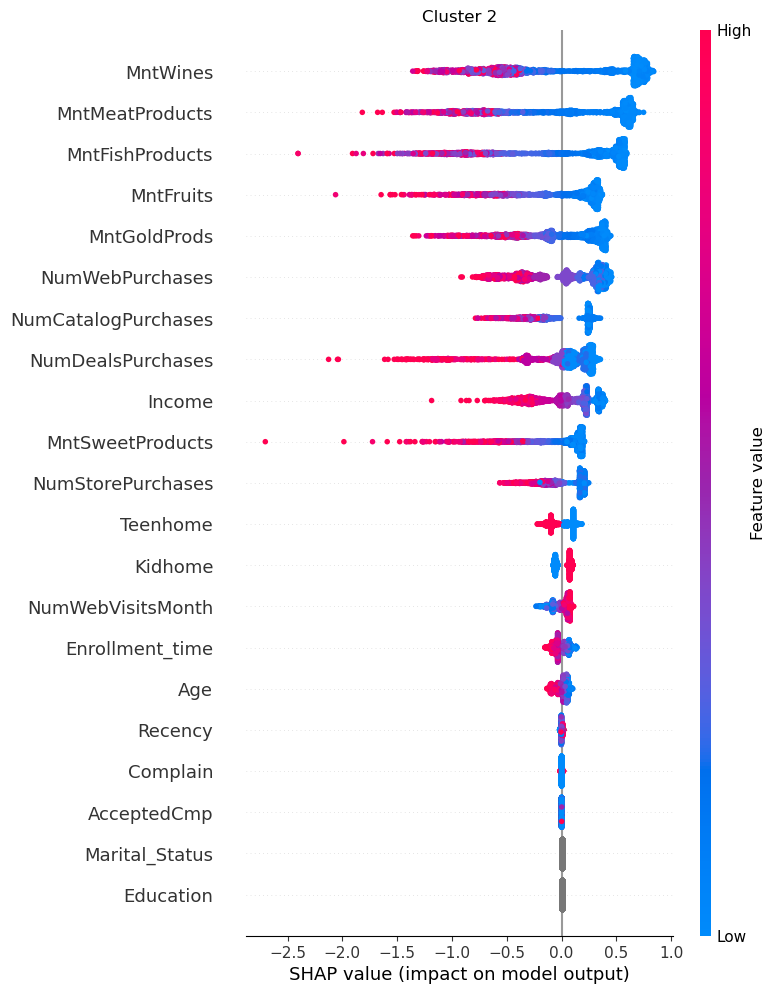

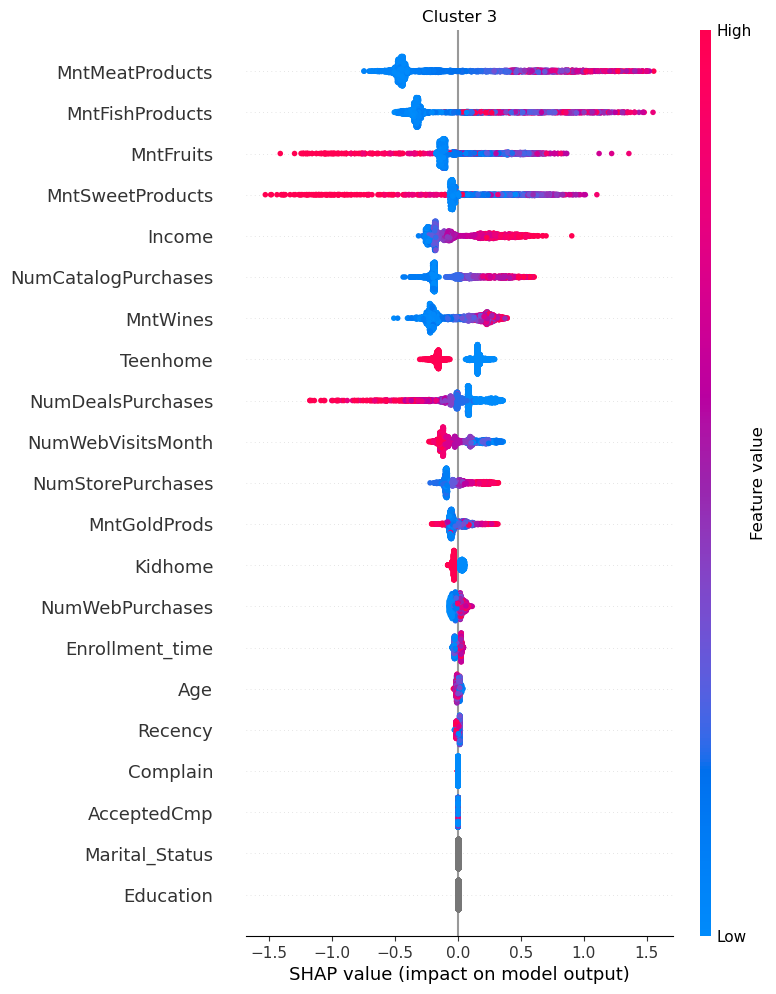

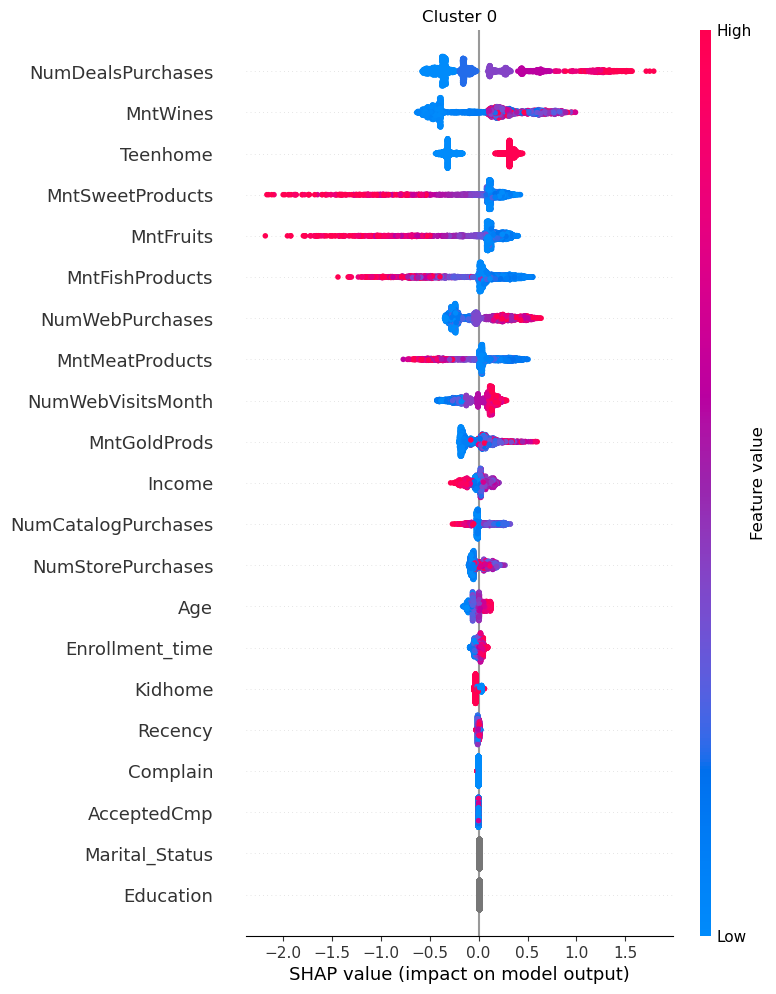

In [32]:
for cnr in df['cluster'].unique():
    shap.summary_plot(shap_values[:, :, cnr], X, max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()
